In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import mlflow
import mlflow.sklearn

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'xgboost'

In [38]:
!C:\Users\Admin\anaconda3\python.exe -m pip install --upgrade pip

  Using cached pip-24.3.1-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 22.3.1
    Uninstalling pip-22.3.1:
      Successfully uninstalled pip-22.3.1


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Admin\\AppData\\Local\\Temp\\pip-uninstall-lszo2dk9\\pip.exe'
Consider using the `--user` option or check the permissions.



In [2]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [3]:
df = pd.read_csv("data/cleaned_v3_data.csv")

In [4]:
X = df.drop(['price'], axis=1)
Y = df['price']

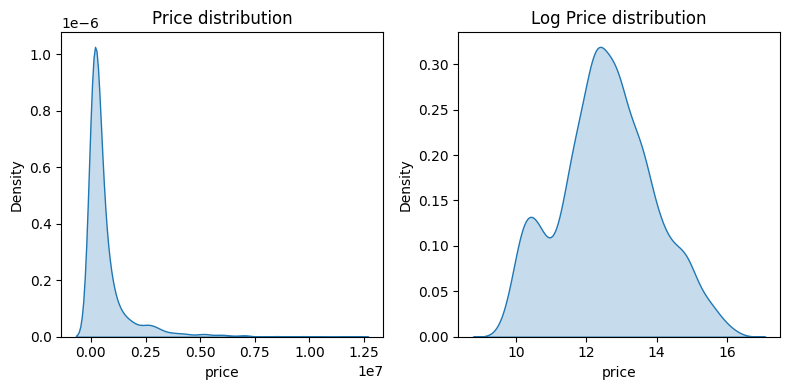

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.kdeplot(Y, ax=axes[0], fill='blue')
axes[0].set_title('Price distribution', fontsize=12)

sns.kdeplot(np.log(Y), ax=axes[1], fill='blue')
axes[1].set_title('Log Price distribution', fontsize=12)

plt.tight_layout()
plt.show()

In [6]:
Y_log = np.log1p(Y)

In [7]:
numerical_cols = ['Case Size', 'Case Thickness', 'Power Reserve', 'Frequency (bph)', 'Jewels', 'Water Resistance (M)', 'Warranty Period']
categorical_cols = X.drop(columns=['Case Size', 'Case Thickness', 'Power Reserve', 'Frequency (bph)', 'Jewels', 'Water Resistance (M)', 'Warranty Period']).columns.tolist()

binary_cat_cols = [
    col for col in categorical_cols
    if df[col].nunique() == 2
]
multi_cat_cols = df[categorical_cols].drop(columns=binary_cat_cols).columns

In [8]:
numerical_cols
binary_cat_cols
multi_cat_cols

Index(['Brand', 'Movement', 'Case Shape', 'Case Material', 'Glass Material',
       'Strap Material', 'Clasp Type', 'Gender', 'Country of Origin', 'Bezel',
       'Case Material Coating'],
      dtype='object')

### Training a Base Model

In [80]:
mlflow.set_experiment("Base Model Label vs OneHot Encoding")

<Experiment: artifact_location='mlflow-artifacts:/727244903144796704', creation_time=1733126963002, experiment_id='727244903144796704', last_update_time=1733126963002, lifecycle_stage='active', name='Base Model Label vs OneHot Encoding', tags={}>

In [81]:
test_results = {}

In [82]:
X_processed = X.copy()

label_encoders = {col: LabelEncoder() for col in categorical_cols}

for col in categorical_cols:
    X_processed[col] = label_encoders[col].fit_transform(X_processed[col])

X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_log, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_cols)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

with mlflow.start_run():
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    y_test_orig = np.expm1(y_test)  
    y_pred_orig = np.expm1(y_pred)  
    
    mlflow.log_param("encoding", "label encoding")

    mse = mean_squared_error(y_test_orig, y_pred_orig)
    mlflow.log_metric("mse", mse)
    print("MSE:", mse)

    rmse = np.sqrt(mse)
    mlflow.log_metric("rmse", rmse)
    print("RMSE:", rmse)

    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    mlflow.log_metric("mae", mae)
    print("MAE:", mae)
    
    test_results['model 1'] = {
        'y_test': y_test_orig,
        'y_pred': y_pred_orig
    }

    print("Model saved with MLflow")

MSE: 660344467738.3046
RMSE: 812615.8180458368
MAE: 302905.3217895884
Model saved with MLflow
🏃 View run amazing-mouse-629 at: http://127.0.0.1:5000/#/experiments/727244903144796704/runs/5b5e2591097f4e9fb8fd1a10ba00e8b8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/727244903144796704


In [83]:
X_processed = X.copy()

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_cols),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_log, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

with mlflow.start_run():
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    y_test_orig = np.expm1(y_test)  
    y_pred_orig = np.expm1(y_pred)  
    
    mlflow.log_param("encoding", "one_hot encoding for all cat cols")

    mse = mean_squared_error(y_test_orig, y_pred_orig)
    mlflow.log_metric("mse", mse)
    print("MSE:", mse)

    rmse = np.sqrt(mse)
    mlflow.log_metric("rmse", rmse)
    print("RMSE:", rmse)
    
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    mlflow.log_metric("mae", mae)
    print("MAE:", mae)
    
    test_results['model 2'] = {
        'y_test': y_test_orig,
        'y_pred': y_pred_orig
    }

    print("Model saved with MLflow")

MSE: 395423723191.8535
RMSE: 628827.2602168687
MAE: 197835.682947397
Model saved with MLflow
🏃 View run adorable-toad-912 at: http://127.0.0.1:5000/#/experiments/727244903144796704/runs/5563785e41464cbf86cac0ac5eeae7a3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/727244903144796704


In [84]:
X_processed = X.copy()

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_cols),
        ('binary_cols', 'passthrough', binary_cat_cols),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
    ])

X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_log, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

with mlflow.start_run():
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    y_test_orig = np.expm1(y_test) 
    y_pred_orig = np.expm1(y_pred)
    
    mlflow.log_param("encoding", "one_hot encoding for multi cat cols")

    mse = mean_squared_error(y_test_orig, y_pred_orig)
    mlflow.log_metric("mse", mse)
    print("MSE:", mse)

    rmse = np.sqrt(mse)
    mlflow.log_metric("rmse", rmse)
    print("RMSE:", rmse)

    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    mlflow.log_metric("mae", mae)
    print("MAE:", mae)

    test_results['model 3'] = {
    'y_test': y_test_orig,
    'y_pred': y_pred_orig
    }

    print("Model saved with MLflow")

MSE: 392211722447.81354
RMSE: 626268.0915133818
MAE: 196899.3744582893
Model saved with MLflow
🏃 View run exultant-crab-514 at: http://127.0.0.1:5000/#/experiments/727244903144796704/runs/a663c27c6e274774ba5c2393d7b324d1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/727244903144796704


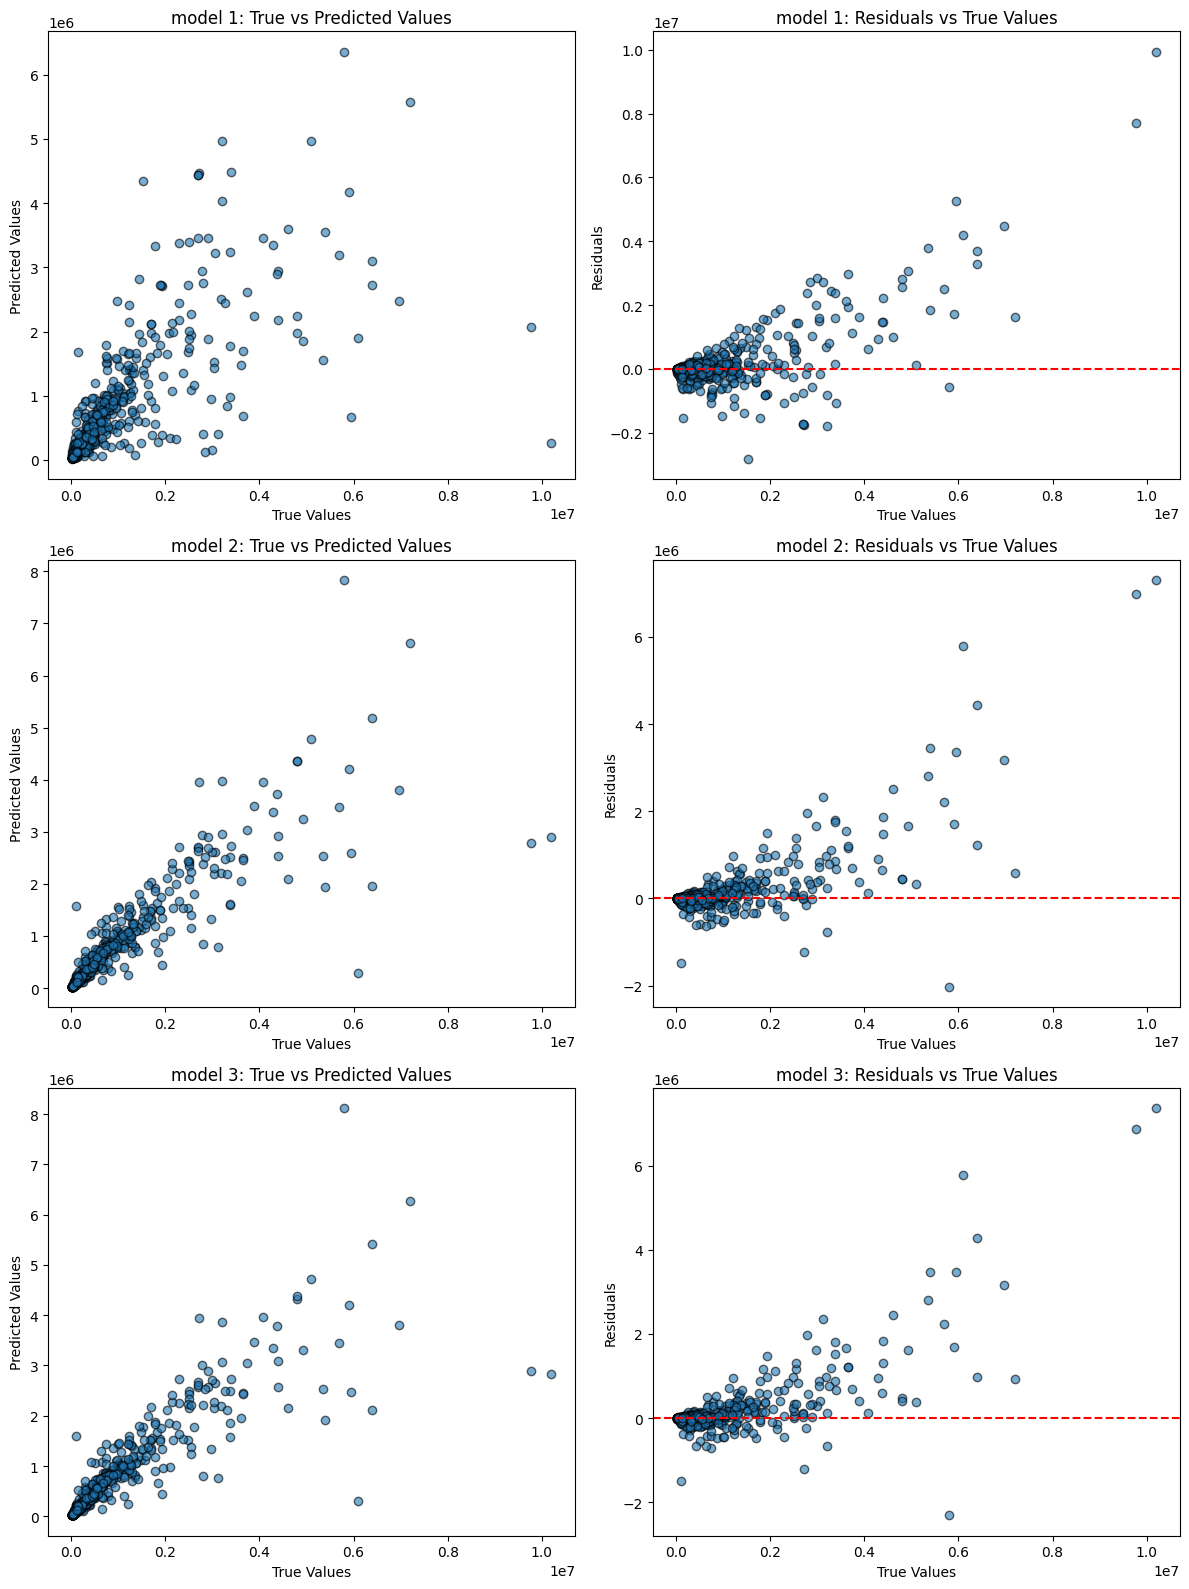

In [62]:
fig, axes = plt.subplots(3, 2, figsize=(12, 16))

for i, model in enumerate(test_results.keys()):
    ytest = test_results[model]['y_test'].values
    ypred = test_results[model]['y_pred']
    
    residuals = ytest - ypred

    ax1 = axes[i, 0]
    ax1.scatter(ytest, ypred, alpha=0.6, edgecolor='k')
    ax1.set_xlabel("True Values")
    ax1.set_ylabel("Predicted Values")
    ax1.set_title(f"{model}: True vs Predicted Values")

    ax2 = axes[i, 1]
    ax2.scatter(ytest, residuals, alpha=0.6, edgecolor='k')
    ax2.axhline(0, color='red', linestyle='--')
    ax2.set_xlabel("True Values")
    ax2.set_ylabel("Residuals")
    ax2.set_title(f"{model}: Residuals vs True Values")

plt.tight_layout()
plt.show()


We can clearly see that OneHot encoding for Multi-class columns shows the best results

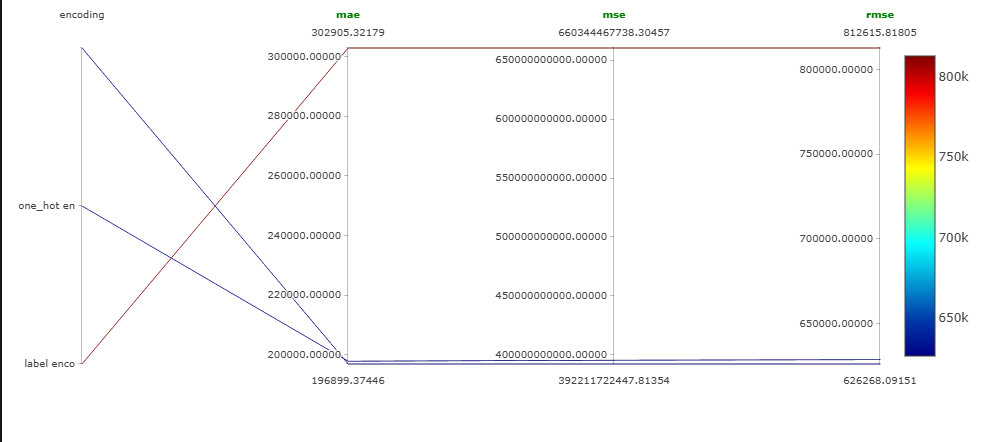

### Experiment 2: Selecting features

In [ ]:
# I have an assumtion that luminosity columns don't contribute much to the performance of the model, lets check that

In [19]:
mlflow.set_experiment("Feature Selection")

<Experiment: artifact_location='mlflow-artifacts:/280729109587890328', creation_time=1733129005643, experiment_id='280729109587890328', last_update_time=1733129005643, lifecycle_stage='active', name='Feature Selection', tags={}>

In [20]:
test_results = {}

In [21]:
features = []
stones = []
luminosity = []
regular_col = []

for col in df.columns:
    if 'feature' in col:
        features.append(col)
    elif 'luminosity' in col:
        luminosity.append(col)
    elif 'precious_stone' in col:
        stones.append(col)
    else:
        regular_col.append(col)

In [23]:
X_processed = X.copy()

binary_cat_cols = [
    col for col in X_processed.columns
    if X_processed[col].nunique() == 2
]
multi_cat_cols = X_processed[categorical_cols].drop(columns=binary_cat_cols).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_cols),
        ('binary_cols', 'passthrough', binary_cat_cols),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
    ])

X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_log, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

with mlflow.start_run():
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_train_pred = pipeline.predict(X_train)

    y_test_orig = np.expm1(y_test) 
    y_pred_orig = np.expm1(y_pred)
    
    mlflow.log_param("name", "base")

    mse = mean_squared_error(y_test_orig, y_pred_orig)
    mlflow.log_metric("mse", mse)
    print("MSE:", mse)

    rmse = np.sqrt(mse)
    mlflow.log_metric("rmse", rmse)
    print("RMSE:", rmse)

    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    mlflow.log_metric("mae", mae)
    print("MAE:", mae)
    
    train_mse = mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred))
    mlflow.log_metric("train_mse", train_mse)
    print("train_mse:", train_mse)

    train_rmse = np.sqrt(train_mse)
    mlflow.log_metric("train_rmse", train_rmse)
    print("train_rmse:", train_rmse) 

    train_mae = mean_absolute_error(np.expm1(y_train), np.expm1(y_train_pred))
    mlflow.log_metric("train_mae", train_mae)
    print("train_mae:", train_mae)

    test_results[f'model base'] = {
    'y_test': y_test_orig,
    'y_pred': y_pred_orig,
    'y_train':  np.expm1(y_train),
    'y_train_pred': np.expm1(y_train_pred)
    }

    print("Model saved with MLflow")

MSE: 392211722447.81354
RMSE: 626268.0915133818
MAE: 196899.3744582893
train_mse: 77397473719.01324
train_rmse: 278204.0145630779
train_mae: 75482.0781892242
Model saved with MLflow
🏃 View run unique-shrike-818 at: http://127.0.0.1:5000/#/experiments/280729109587890328/runs/befd3fbb66514ee980a219637c03b0ba
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/280729109587890328


In [ ]:
for i, col_to_drop in enumerate([luminosity, features, stones]):
    
    X_processed = X.drop(columns=col_to_drop)

    binary_cat_cols = [
        col for col in X_processed.columns
        if X_processed[col].nunique() == 2
    ]
    multi_cat_cols = X_processed.drop(columns=binary_cat_cols + numerical_cols).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num_scaler', StandardScaler(), numerical_cols),
            ('binary_cols', 'passthrough', binary_cat_cols),
            ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
        ])

    X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_log, test_size=0.2, random_state=42)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ])
    
    if i == 0:
        name = "lum"
    elif i == 1:
        name = "feat"
    else:
        name = "stones"

    with mlflow.start_run(run_name=f"no {name}"):
        
        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)
        y_train_pred = pipeline.predict(X_train)

        y_test_orig = np.expm1(y_test) 
        y_pred_orig = np.expm1(y_pred)

        mlflow.log_param("name", name)

        mse = mean_squared_error(y_test_orig, y_pred_orig)
        mlflow.log_metric("mse", mse)
        print("MSE:", mse)

        rmse = np.sqrt(mse)
        mlflow.log_metric("rmse", rmse)
        print("RMSE:", rmse)

        mae = mean_absolute_error(y_test_orig, y_pred_orig)
        mlflow.log_metric("mae", mae)
        print("MAE:", mae)
        
        train_mse = mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred))
        mlflow.log_metric("train_mse", train_mse)
        print("train_mse:", train_mse)
        
        train_rmse = np.sqrt(train_mse)
        mlflow.log_metric("train_rmse", train_rmse)
        print("train_rmse:", train_rmse) 
        
        train_mae = mean_absolute_error(np.expm1(y_train), np.expm1(y_train_pred))
        mlflow.log_metric("train_mae", train_mae)
        print("train_mae:", train_mae)
        
        test_results[f'model {name}'] = {
        'y_test': y_test_orig,
        'y_pred': y_pred_orig,
        'y_train':  np.expm1(y_train),
        'y_train_pred': np.expm1(y_train_pred)
        }

        print("Model saved with MLflow")

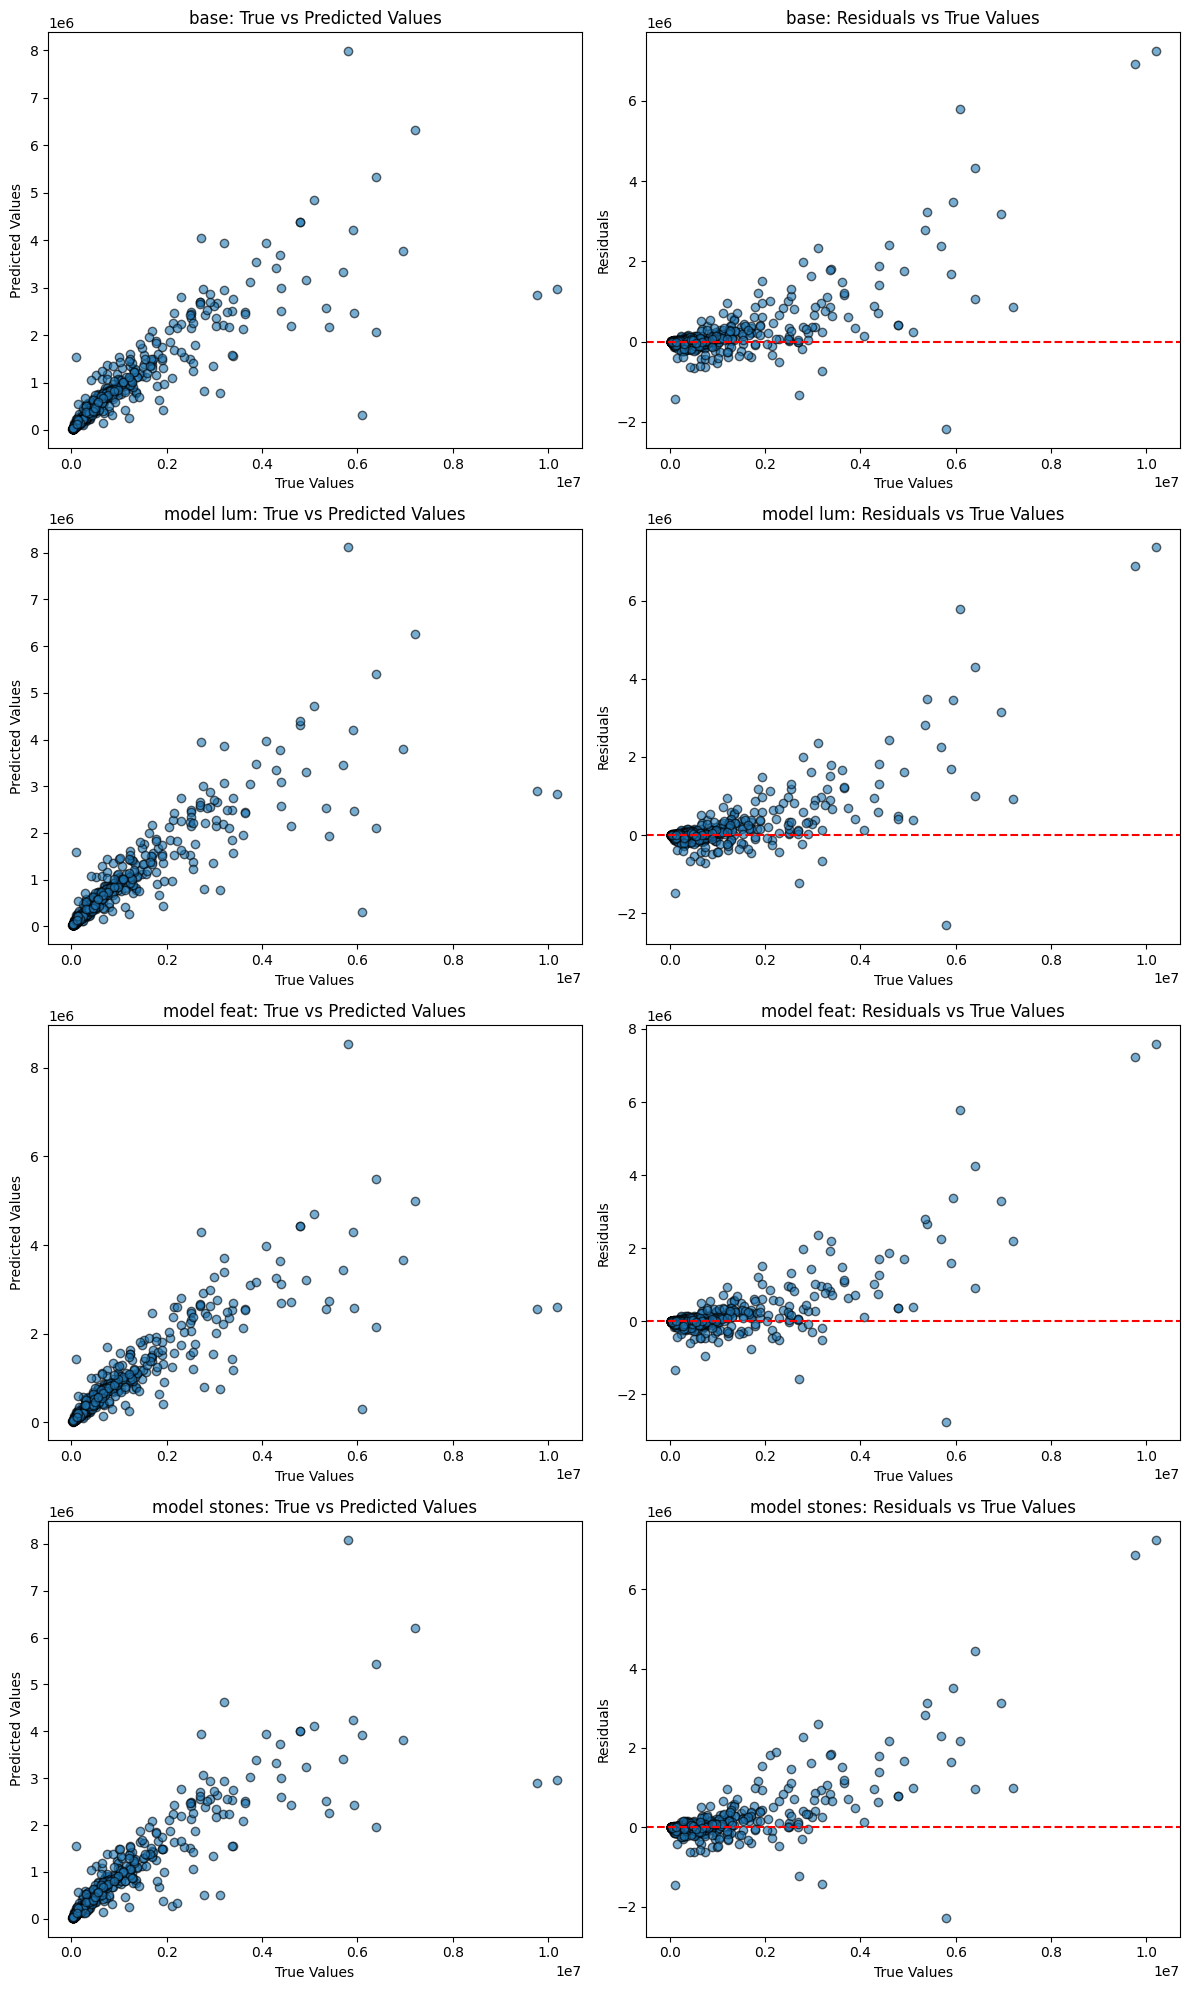

In [111]:
fig, axes = plt.subplots(4, 2, figsize=(12, 20))

for i, model in enumerate(['base','model lum', 'model feat','model stones']):
    ytest = test_results[model]['y_test'].values
    ypred = test_results[model]['y_pred']
    
    residuals = ytest - ypred

    ax1 = axes[i, 0]
    ax1.scatter(ytest, ypred, alpha=0.6, edgecolor='k')
    ax1.set_xlabel("True Values")
    ax1.set_ylabel("Predicted Values")
    ax1.set_title(f"{model}: True vs Predicted Values")

    ax2 = axes[i, 1]
    ax2.scatter(ytest, residuals, alpha=0.6, edgecolor='k')
    ax2.axhline(0, color='red', linestyle='--')
    ax2.set_xlabel("True Values")
    ax2.set_ylabel("Residuals")
    ax2.set_title(f"{model}: Residuals vs True Values")

plt.tight_layout()
plt.show()


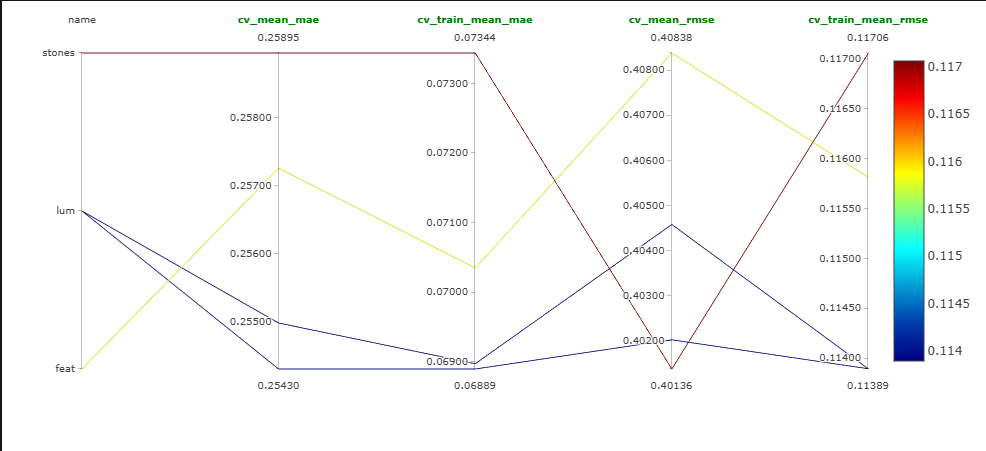

In [29]:
## Cross validation

In [26]:
mlflow.set_experiment("CV features")

2024/12/02 17:02:12 INFO mlflow.tracking.fluent: Experiment with name 'CV features' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/202848682694580044', creation_time=1733139132819, experiment_id='202848682694580044', last_update_time=1733139132819, lifecycle_stage='active', name='CV features', tags={}>

In [27]:
X_processed = X.copy()

binary_cat_cols = [
    col for col in X_processed.columns
    if X_processed[col].nunique() == 2
]
multi_cat_cols = X_processed[categorical_cols].drop(columns=binary_cat_cols).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_cols),
        ('binary_cols', 'passthrough', binary_cat_cols),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

with mlflow.start_run():
    cv_results = cross_validate(
        pipeline, X_processed, Y_log, 
        scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
        cv=5, return_train_score=True
    )

    mean_mse = -cv_results['test_neg_mean_squared_error'].mean()
    mean_mae = -cv_results['test_neg_mean_absolute_error'].mean()
    mean_train_mse = -cv_results['train_neg_mean_squared_error'].mean()
    mean_train_mae = -cv_results['train_neg_mean_absolute_error'].mean()

    mlflow.log_param("name", "base")
    mlflow.log_metric("cv_mean_mse", mean_mse)
    mlflow.log_metric("cv_mean_rmse", np.sqrt(mean_mse))
    mlflow.log_metric("cv_mean_mae", mean_mae)
    mlflow.log_metric("cv_train_mean_mse", mean_train_mse)
    mlflow.log_metric("cv_train_mean_rmse", np.sqrt(mean_train_mse))
    mlflow.log_metric("cv_train_mean_mae", mean_train_mae)

    print(f"Model base:")
    print("CV Mean MSE:", mean_mse)
    print("CV Mean RMSE:", np.sqrt(mean_mse))
    print("CV Mean MAE:", mean_mae)
    print("CV Train Mean MSE:", mean_train_mse)
    print("CV Train Mean RMSE:", np.sqrt(mean_train_mse))
    print("CV Train Mean MAE:", mean_train_mae)

Model lum:
CV Mean MSE: 0.16161366642856573
CV Mean RMSE: 0.4020120227413177
CV Mean MAE: 0.25430129914172284
CV Train Mean MSE: 0.012971698870454459
CV Train Mean RMSE: 0.11389336622672305
CV Train Mean MAE: 0.06889401346925612
🏃 View run abrasive-toad-496 at: http://127.0.0.1:5000/#/experiments/202848682694580044/runs/f28644c824f24715b64b2134c676e826
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/202848682694580044


In [28]:
from sklearn.model_selection import cross_validate

for i, col_to_drop in enumerate([luminosity, features, stones]):
    X_processed = X.drop(columns=col_to_drop)

    binary_cat_cols = [
        col for col in X_processed.columns
        if X_processed[col].nunique() == 2
    ]
    multi_cat_cols = X_processed.drop(columns=binary_cat_cols + numerical_cols).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num_scaler', StandardScaler(), numerical_cols),
            ('binary_cols', 'passthrough', binary_cat_cols),
            ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
        ]
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ])
    
    if i == 0:
        name = "lum"
    elif i == 1:
        name = "feat"
    else:
        name = "stones"

    with mlflow.start_run(run_name=f"no {name}"):
        cv_results = cross_validate(
            pipeline, X_processed, Y_log, 
            scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
            cv=5, return_train_score=True
        )

        mean_mse = -cv_results['test_neg_mean_squared_error'].mean()
        mean_mae = -cv_results['test_neg_mean_absolute_error'].mean()
        mean_train_mse = -cv_results['train_neg_mean_squared_error'].mean()
        mean_train_mae = -cv_results['train_neg_mean_absolute_error'].mean()

        mlflow.log_param("name", name)
        mlflow.log_metric("cv_mean_mse", mean_mse)
        mlflow.log_metric("cv_mean_rmse", np.sqrt(mean_mse))
        mlflow.log_metric("cv_mean_mae", mean_mae)
        mlflow.log_metric("cv_train_mean_mse", mean_train_mse)
        mlflow.log_metric("cv_train_mean_rmse", np.sqrt(mean_train_mse))
        mlflow.log_metric("cv_train_mean_mae", mean_train_mae)

        print(f"Model {name}:")
        print("CV Mean MSE:", mean_mse)
        print("CV Mean RMSE:", np.sqrt(mean_mse))
        print("CV Mean MAE:", mean_mae)
        print("CV Train Mean MSE:", mean_train_mse)
        print("CV Train Mean RMSE:", np.sqrt(mean_train_mse))
        print("CV Train Mean MAE:", mean_train_mae)

Model lum:
CV Mean MSE: 0.16368036834155225
CV Mean RMSE: 0.40457430509308456
CV Mean MAE: 0.2549778325678237
CV Train Mean MSE: 0.012971154416057359
CV Train Mean RMSE: 0.1138909760080111
CV Train Mean MAE: 0.06897009095701354
🏃 View run no lum at: http://127.0.0.1:5000/#/experiments/202848682694580044/runs/019be667538d42bc923739c4050f9315
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/202848682694580044
Model feat:
CV Mean MSE: 0.16677725462430334
CV Mean RMSE: 0.4083837100378801
CV Mean MAE: 0.25725688023653265
CV Train Mean MSE: 0.013412910422018592
CV Train Mean RMSE: 0.11581412013229904
CV Train Mean MAE: 0.07034589431307203
🏃 View run no feat at: http://127.0.0.1:5000/#/experiments/202848682694580044/runs/13fecf6bd69c47c7bd6af21d44a7a2ba
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/202848682694580044
Model stones:
CV Mean MSE: 0.1610926229197423
CV Mean RMSE: 0.4013634548881379
CV Mean MAE: 0.2589520791167813
CV Train Mean MSE: 0.013702852984483252
CV Tra

### Model Selection

In [ ]:
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {
            'regressor__fit_intercept': [True, False],
            'regressor__positive': [False, True]
        }
    },
    'Ridge Regression': {
        'model': Ridge(),
        'params': {
            'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
            'regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr'],
            'regressor__fit_intercept': [True, False],
            'regressor__positive': [False, True]
        }
    },
    'Lasso Regression': {
        'model': Lasso(),
        'params': {
            'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
            'regressor__selection': ['cyclic', 'random'],
            'regressor__fit_intercept': [True, False],
            'regressor__positive': [False, True]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [100, 200, 300, 500],
            'regressor__max_depth': [None, 10, 20, 30],
            'regressor__min_samples_split': [2, 5, 10, 15],
            'regressor__min_samples_leaf': [1, 2, 4],
            'regressor__max_features': ['auto', 'sqrt', 'log2'],
            'regressor__bootstrap': [True, False],
            'regressor__criterion': ['mse', 'mae']
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [100, 200, 300],
            'regressor__learning_rate': [0.01, 0.1, 0.3],
            'regressor__max_depth': [3, 5, 7],
            'regressor__min_samples_split': [2, 5, 10],
            'regressor__min_samples_leaf': [1, 2, 4],
            'regressor__subsample': [0.8, 0.9, 1.0],
            'regressor__max_features': ['auto', 'sqrt', 'log2']
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'regressor__kernel': ['rbf', 'linear', 'poly'],
            'regressor__C': [0.1, 1, 10, 100],
            'regressor__epsilon': [0.1, 0.2, 0.5],
            'regressor__gamma': ['scale', 'auto', 0.1, 1],
            'regressor__shrinking': [True, False]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
            'regressor__max_depth': [None, 10, 20, 30, 50],
            'regressor__min_samples_split': [2, 5, 10, 15],
            'regressor__min_samples_leaf': [1, 2, 4],
            'regressor__max_features': [None, 'auto', 'sqrt', 'log2'],
            'regressor__splitter': ['best', 'random'],
            'regressor__criterion': ['mse', 'mae', 'friedman_mse']
        }
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [100, 200, 300, 500],
            'regressor__learning_rate': [0.01, 0.1, 0.3],
            'regressor__max_depth': [3, 5, 7, 10],
            'regressor__min_child_weight': [1, 3, 5],
            'regressor__subsample': [0.6, 0.8, 1.0],
            'regressor__colsample_bytree': [0.6, 0.8, 1.0],
            'regressor__gamma': [0, 0.1, 0.3],
            'regressor__reg_alpha': [0, 0.1, 1],
            'regressor__reg_lambda': [0, 0.1, 1]
        }
    },
    'CatBoost': {
        'model': CatBoostRegressor(random_state=42, verbose=0),
        'params': {
            'regressor__iterations': [100, 200, 300, 500],
            'regressor__learning_rate': [0.01, 0.1, 0.3],
            'regressor__depth': [4, 6, 8, 10],
            'regressor__l2_leaf_reg': [1, 3, 5, 10],
            'regressor__rsm': [0.6, 0.8, 1.0],
            'regressor__random_strength': [0, 0.1, 1],
            'regressor__bagging_temperature': [0, 1],
            'regressor__border_count': [32, 64, 128],
            'regressor__loss_function': ['RMSE', 'MAE', 'MAPE']
        }
    },
    'LightGBM': {
        'model': LGBMRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [100, 200, 300, 500],
            'regressor__learning_rate': [0.01, 0.1, 0.3],
            'regressor__max_depth': [3, 5, 7, -1],
            'regressor__num_leaves': [31, 50, 70, 100],
            'regressor__min_child_samples': [20, 50, 100],
            'regressor__subsample': [0.6, 0.8, 1.0],
            'regressor__colsample_bytree': [0.6, 0.8, 1.0],
            'regressor__reg_alpha': [0, 0.1, 1],
            'regressor__reg_lambda': [0, 0.1, 1],
            'regressor__min_split_gain': [0, 0.1, 0.3],
            'regressor__boosting_type': ['gbdt', 'dart', 'goss']
        }
    }
}


In [ ]:
def create_model_experiments(X, Y_log, numerical_cols, categorical_cols):

    X_processed = X.copy()
    binary_cat_cols = [
        col for col in X_processed.columns
        if X_processed[col].nunique() == 2
    ]
    multi_cat_cols = X_processed[categorical_cols].drop(columns=binary_cat_cols).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num_scaler', StandardScaler(), numerical_cols),
            ('binary_cols', 'passthrough', binary_cat_cols),
            ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
        ])

    cat_indices = []
    cat_feature_mask = X_processed.columns.isin(categorical_cols)
    cat_indices = list(np.where(cat_feature_mask)[0])

    results = {}

    for model_name, model_info in models.items():

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model_info['model'])
        ])

        if model_info['params']:

            if model_name == 'CatBoost':
                grid_search = GridSearchCV(
                    pipeline, 
                    param_grid=model_info['params'], 
                    cv=5, 
                    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
                    refit='neg_mean_squared_error'
                )

                grid_search.fit(X_processed, Y_log, 
                                regressor__cat_features=cat_indices)
            
            elif model_name == 'LightGBM':
                grid_search = GridSearchCV(
                    pipeline, 
                    param_grid=model_info['params'], 
                    cv=5, 
                    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
                    refit='neg_mean_squared_error'
                )

                grid_search.fit(X_processed, Y_log, 
                                regressor__categorical_feature=cat_indices)
            
            else:
                grid_search = GridSearchCV(
                    pipeline, 
                    param_grid=model_info['params'], 
                    cv=5, 
                    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
                    refit='neg_mean_squared_error'
                )
                grid_search.fit(X_processed, Y_log)
        else:
            grid_search = pipeline
            grid_search.fit(X_processed, Y_log)

        with mlflow.start_run(run_name=f"experiment_{model_name}"):

            cv_results = cross_validate(
                grid_search, X_processed, Y_log, 
                scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
                cv=5, return_train_score=True
            )

            mean_mse = -cv_results['test_neg_mean_squared_error'].mean()
            mean_mae = -cv_results['test_neg_mean_absolute_error'].mean()
            mean_train_mse = -cv_results['train_neg_mean_squared_error'].mean()
            mean_train_mae = -cv_results['train_neg_mean_absolute_error'].mean()

            mlflow.log_param("model", model_name)
            mlflow.log_metric("cv_mean_mse", mean_mse)
            mlflow.log_metric("cv_mean_rmse", np.sqrt(mean_mse))
            mlflow.log_metric("cv_mean_mae", mean_mae)
            mlflow.log_metric("cv_train_mean_mse", mean_train_mse)
            mlflow.log_metric("cv_train_mean_rmse", np.sqrt(mean_train_mse))
            mlflow.log_metric("cv_train_mean_mae", mean_train_mae)

            if model_info['params']:
                best_params = grid_search.best_params_ if hasattr(grid_search, 'best_params_') else {}
                for param, value in best_params.items():
                    mlflow.log_param(param, value)

            results[model_name] = {
                'MSE': mean_mse,
                'RMSE': np.sqrt(mean_mse),
                'MAE': mean_mae,
                'Train MSE': mean_train_mse,
                'Train RMSE': np.sqrt(mean_train_mse),
                'Train MAE': mean_train_mae
            }

            print(f"Model: {model_name}")
            print("CV Mean MSE:", mean_mse)
            print("CV Mean RMSE:", np.sqrt(mean_mse))
            print("CV Mean MAE:", mean_mae)
            print("CV Train Mean MSE:", mean_train_mse)
            print("CV Train Mean RMSE:", np.sqrt(mean_train_mse))
            print("CV Train Mean MAE:", mean_train_mae)
            print("-" * 50)

    return results